<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)
  
  * [EXTRA] Avaliar o impacto do Dropout

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

All MLPs draws was maded at http://alexlenail.me/NN-SVG/index.html

In [12]:
#Importing Librarys 📚
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time # for time mesurment
import tensorflow as tf
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from IPython.display import HTML

print(tf.__version__)

2.8.2


# Regression

The regression problem consists of searching for a mathematical expression whose function f(x) can describe a given set of data. This technique is used when you have the points of a certain measure but not the law that describes that phenomenon.

In general, any curve can be associated with a set of nth-order polynomials or a set of straight lines. For the case of a neural network, the non-linearity of how the weights influence a given function is difficult to describe, however it has the generalization capacity similar to linear regression.

Below we can see an example of points being fitted by a curve according to the training epochs.

<img src="https://www.cs.toronto.edu/~frossard/post/multiple_linear_regression/multiple_lreg.gif" width=500>

font: https://www.cs.toronto.edu/~frossard/post/multiple_linear_regression/


Here I will present 5 topologies of a Multilayer Perceptron, gradually increasing the number of neurons and number of layers. For each topology I will change the hyperparameters of "momentun", "regularization" and "droup out. Having a total of 6 variations.

* No Regularization, no Dropoutr, no Momentun.
* 0.2 Regularization, no Dropout, no Momentun.
* No Regularization, 0.2 Dropout, no Momentun.
* No Regularization, no Dropoutr, 0.2 Momentun.
* 0.2 Regularization, without Dropoutr, 0.2 Momentun.
* 0.2 Regularization, 0.2 Dropoutr, 0.2 Momentun.

The activation functions are the same in all topologies with the exception of topology 5 which follows the same structure as topology 4.

In this way, we can observe how the regularization is sensitive to these hyperparameters.

## Dataset

This dataset refers to the Power Spectrum Desity Function (PSD) of the two-point correlation function of the Cosmic Background Radiation and is of great importance for the determination of the cosmological parameters. This data carry the information of how matter are splitet in the larg scale universe. 

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/Sound%20waves%20in%20space%20Baryon%20Acoustic%20Oscillations.gif?raw=true"> 

font: https://youtu.be/jpXuYc-wzk4

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology


In [2]:
!wget "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt"

--2022-07-15 00:30:37--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’

product-action?COSM     [    <=>             ] 166.55K   197KB/s    in 0.8s    

2022-07-15 00:30:39 (197 KB/s) - ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’ saved [170547]



In [3]:
df = pd.read_fwf('product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["id","l", "Dl", "+dDl", "-dDl"]
df.drop('id', axis=1, inplace=True) #droping id Column

In [4]:
#Normalize data
df.l =  (df.l - df.l.mean()) / df.l.std()
df.Dl =  (df.Dl - df.Dl.mean()) / df.Dl.std()
df['+dDl'] =  (df['+dDl'] - df['+dDl'].mean()) / df['+dDl'].std()
df['+dDl'] =  (df['-dDl'] - df['-dDl'].mean()) / df['-dDl'].std()

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

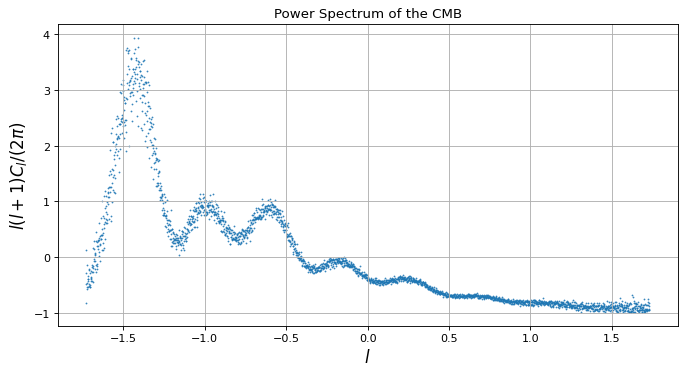

In [5]:
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.3)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
#plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.grid()
plt.plot()


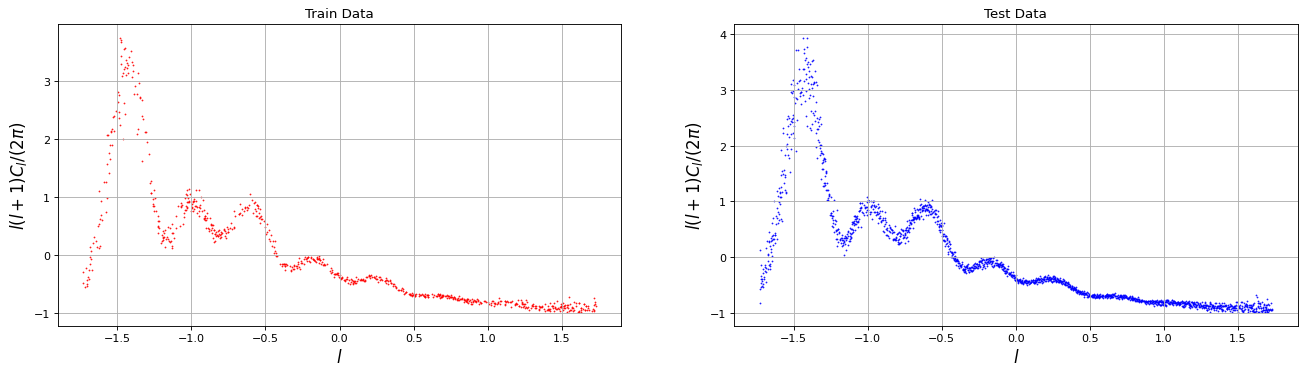

In [6]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
# print(len(x_train))
# print(len(x_test))
figure(figsize=(20,5),dpi=80)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.title('Train Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.grid()
#plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.title('Test Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.grid()
#plt.xscale('log')
plt.show()


## Comun parametes

In [7]:
#Paramentes
adam = tf.keras.optimizers.Adam()

## Topology 1

To attempt to build a network capable of finding a regression law for these problems, we will generate 5 different network topologies. The first will be the simple and classic case of a perceptron and the second will increase the number of layers and the number of neurons.

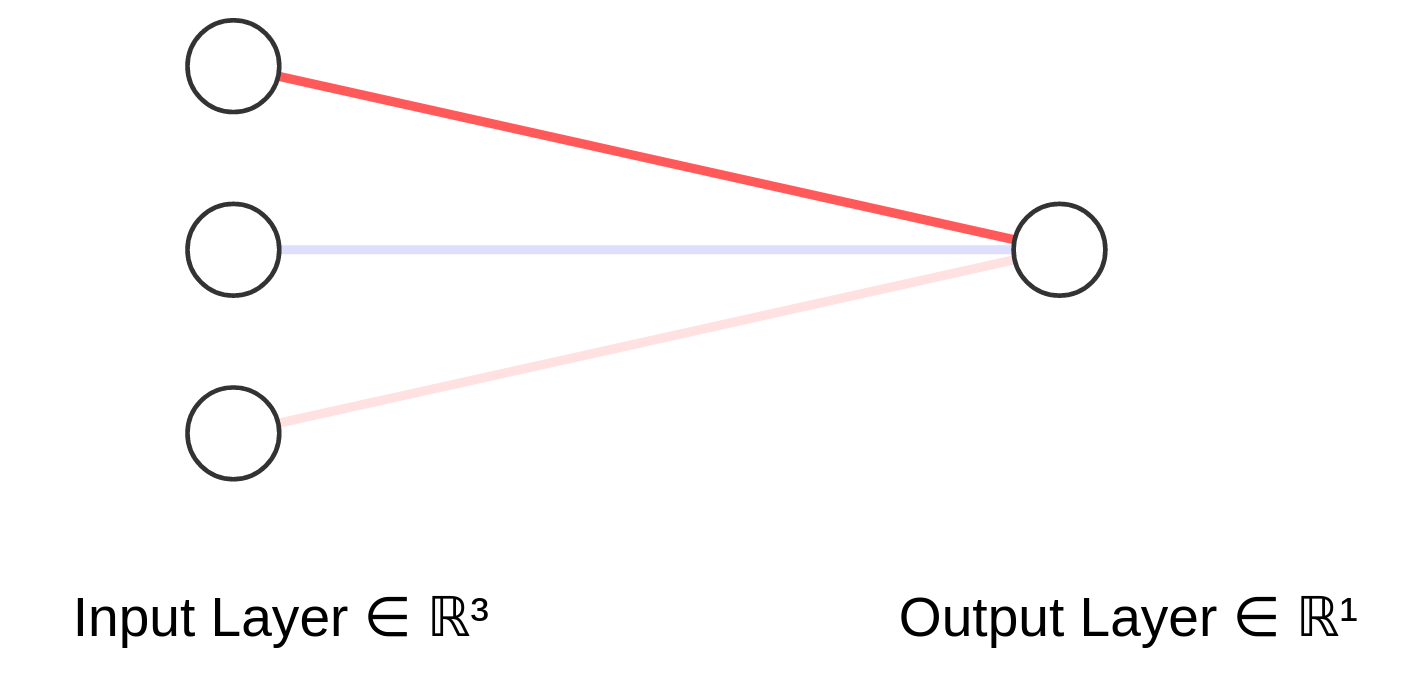

### Models

In [8]:
model_1 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_1.append(keras.Sequential())
  model_1[i].add(keras.layers.Dense(units=3,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_1[i].add(Dropout(dropo[i]))
  model_1[i].add(keras.layers.Dense(units=1,kernel_regularizer=l2(regul[i]), activation="linear"))
  model_1[i].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

### Training

In [ ]:
#O que é isso?
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___1 = []
endti___1 = []
history_1 = []
for i in range(len(regul)):
  start___1.append(time.time())
  history_1.append(
    model_1[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___1.append(time.time())

### Results

In [10]:
#Time Running Out
for i in range(len(start___1)):
  print(round((    endti___1[i]- start___1[i])/60,5),'minuts')
print(round((      endti___1[-1]-start___1[0])/60,5),'minuts TOTAL')

3.37923 minuts
4.37238 minuts
4.37604 minuts
4.37286 minuts
4.37763 minuts
4.37547 minuts
25.25361 minuts TOTAL


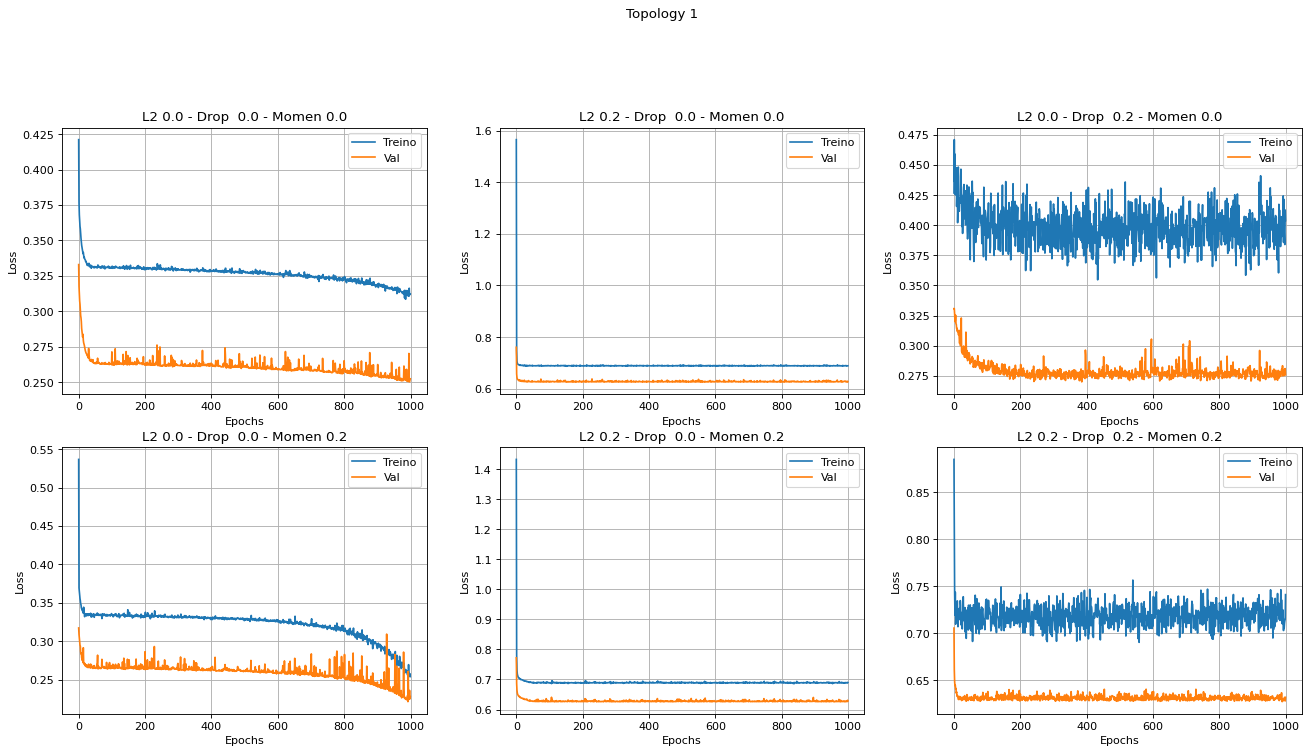

In [11]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("Topology 1")
for i in range(len(model_1)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(history_1[i].history['loss'], label="Treino")
  plt.plot(history_1[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
  plt.legend()

### Avaliation

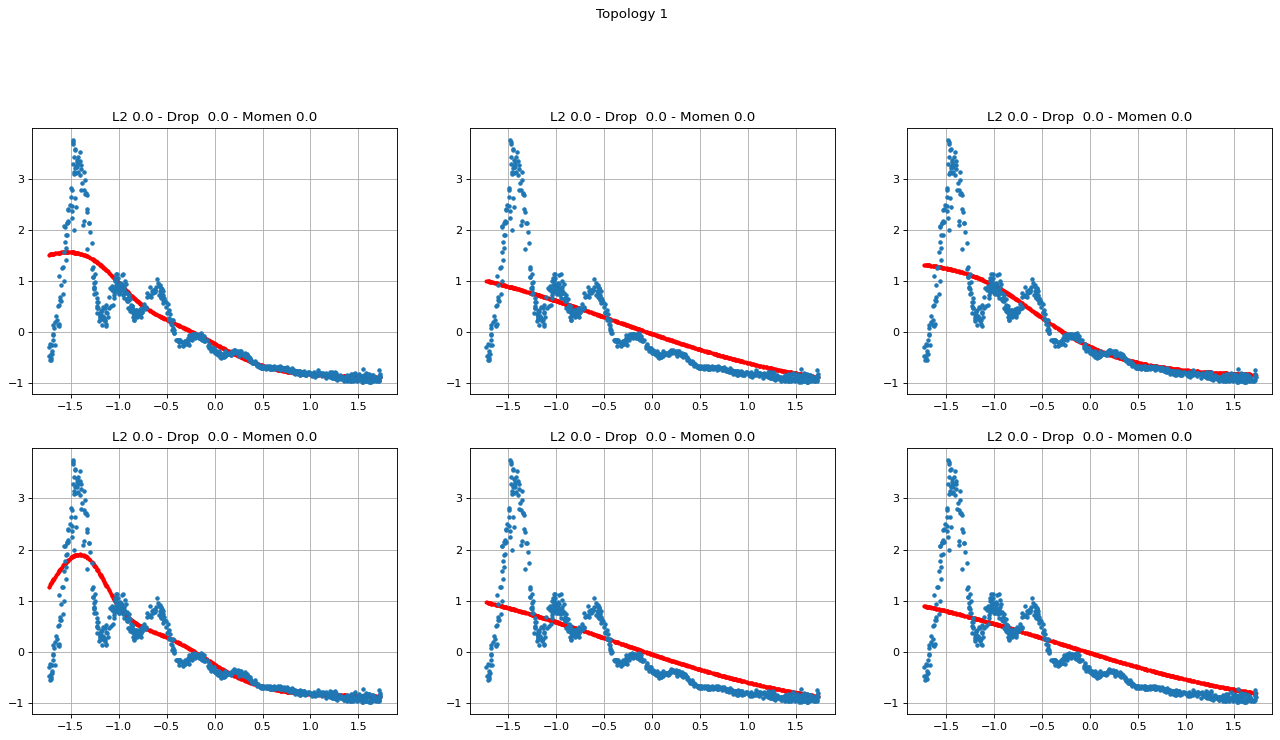

In [12]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 1')
for i in range(len( model_1)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_1[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
  plt.grid()
#plt.xscale('log')

In [13]:
score_1 = []
for i in range(len(           model_1)): 
  score_1.append(             model_1[i].evaluate(x_test, y_test, verbose=0))
  print('Model_1'+str(i))
  print("Test loss:",   round(score_1[i][0],5))
  print("Test metric:", round(score_1[i][1],5),'\n')


Model_10
Test loss: 0.26345
Test metric: 0.27141 

Model_11
Test loss: 0.63366
Test metric: 0.37588 

Model_12
Test loss: 0.28355
Test metric: 0.27848 

Model_13
Test loss: 0.2203
Test metric: 0.25805 

Model_14
Test loss: 0.63363
Test metric: 0.37773 

Model_15
Test loss: 0.63645
Test metric: 0.40949 



## Topology 2 

1. 10 Neurons on input layer
2. 10 Neurons on 1º hidden layer
3. 10 Neurons on 2º hidden layer
4. 10 Neurons on 3º hidden layer
5. 1 Neurons on output layer

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top2.png?raw=true">

### Models



In [14]:
model_2 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_2.append(keras.Sequential())
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))  
  model_2[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_2[i].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])


### Training

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___2 = []
endti___2 = []
history_2 = []
for i in range(len(regul)):
  start___2.append(time.time())
  history_2.append(
    model_2[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___2.append(time.time())

### Results

In [16]:
#Time Running Out
for i in range(len(start___2)):
  print(round((    endti___2[i]- start___2[i])/60,5),'minuts')
print(round((      endti___2[-1]-start___2[0])/60,5),'minuts TOTAL')

4.37773 minuts
3.96365 minuts
4.3484 minuts
5.38481 minuts
5.37984 minuts
5.38166 minuts
28.83609 minuts TOTAL


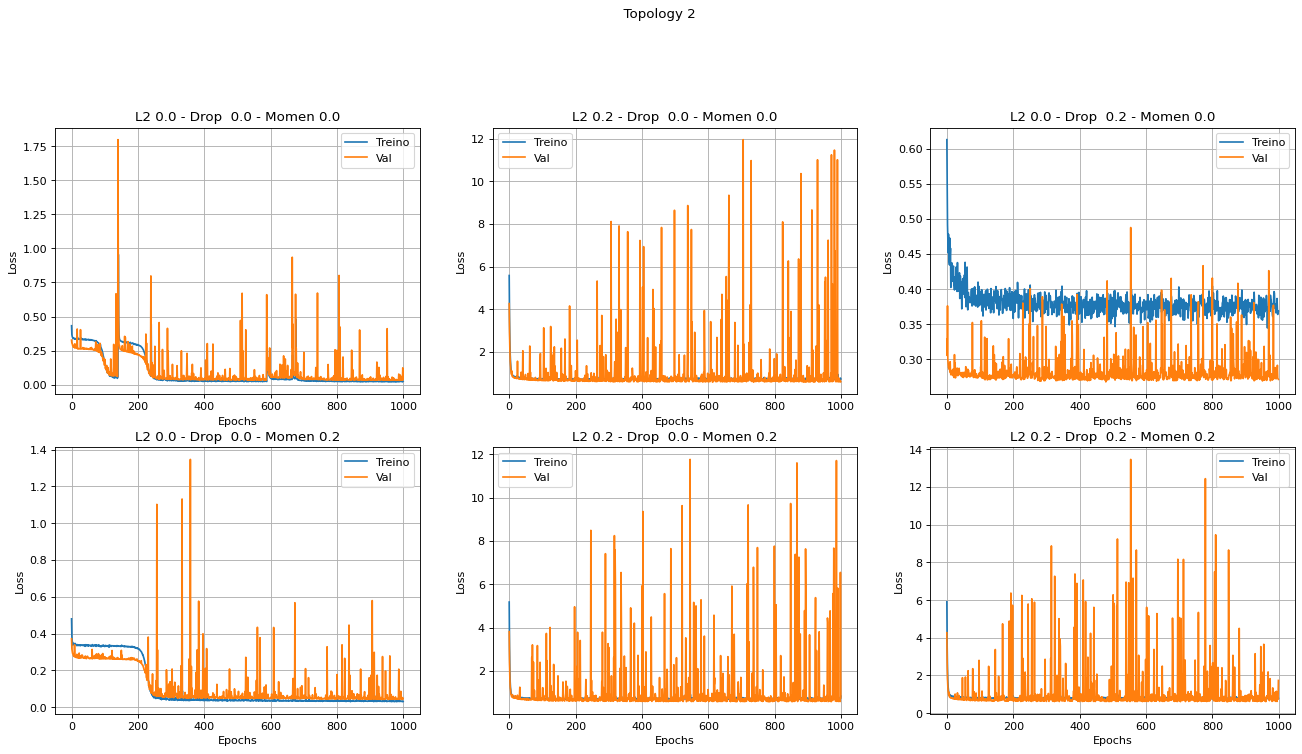

In [17]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 2")
for i in range(len(model_2)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_2[i].history['loss'], label="Treino")
  plt.plot(      history_2[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
  plt.legend()

### Avaliation

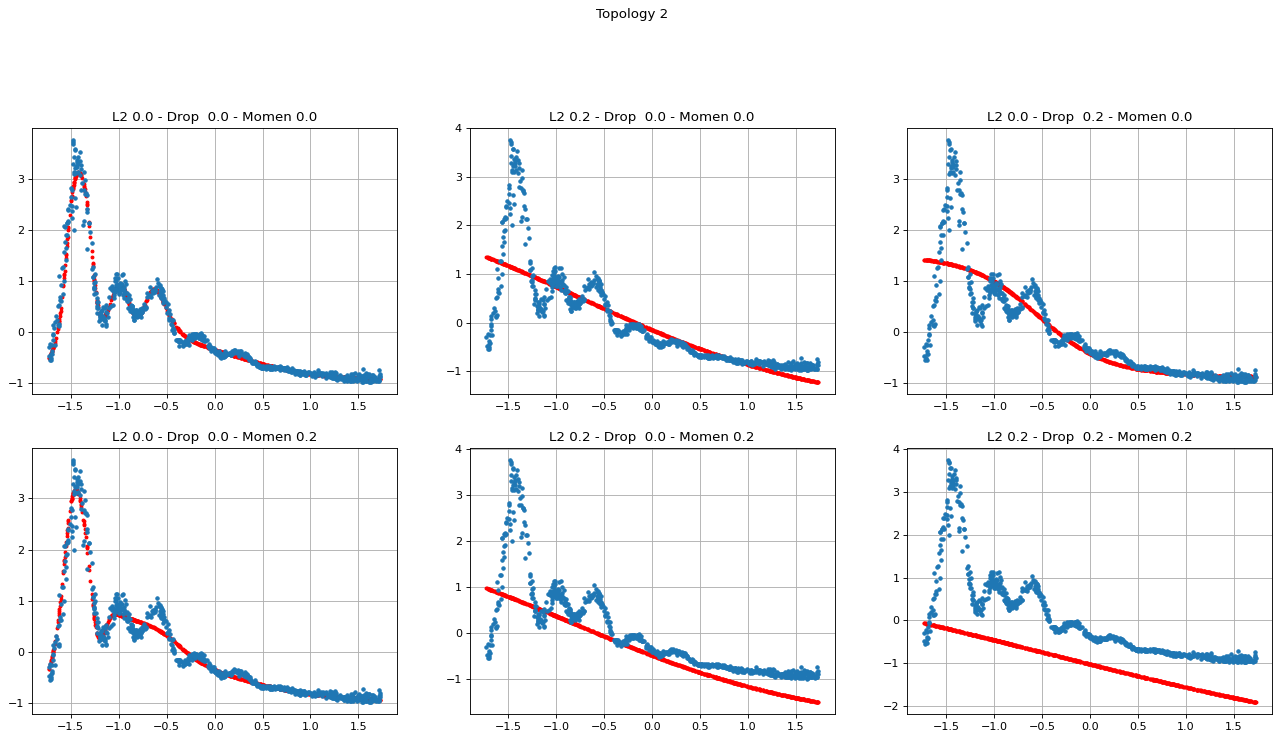

In [18]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 2')
for i in range(len( model_2)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_2[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
#plt.xscale('log')

In [19]:
score_2 = []
for i in range(len(           model_2)): 
  score_2.append(             model_2[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_2'+str(i))
  print("Test loss:",   round(score_2[i][0],5))
  print("Test metric:", round(score_2[i][1],5),'\n')

Model_20
Test loss: 0.02986
Test metric: 0.09919 

Model_21
Test loss: 0.60836
Test metric: 0.31691 

Model_22
Test loss: 0.28058
Test metric: 0.28315 

Model_23
Test loss: 0.03772
Test metric: 0.12406 

Model_24
Test loss: 0.75978
Test metric: 0.46939 

Model_25
Test loss: 1.64439
Test metric: 1.009 



## Topology 3


1. 50 Neurons on input layer
2. 40 Neurons on 1º hidden layer
3. 30 Neurons on 2º hidden layer
4. 20 Neurons on 3º hidden layer
4. 10 Neurons on 4º hidden layer
5. 1 Neurons on output layer


<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top3.png?raw=true">

### Models


In [20]:
model_3 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_3.append(keras.Sequential())
  model_3[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=40,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=30,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=20,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_3[i].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])


### Training

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___3 = []
endti___3 = []
history_3 = []
for i in range(len(regul)):
  start___3.append(time.time())
  history_3.append(model_3[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___3.append(time.time())

### Results

In [22]:
#Time Running Out
for i in range(len(start___3)):
  print(round((    endti___3[i]- start___3[i])/60,5),'minuts')
print(round((      endti___3[-1]-start___3[0])/60,5),'minuts TOTAL')

4.37939 minuts
4.37534 minuts
5.37727 minuts
5.38231 minuts
5.3802 minuts
5.38262 minuts
30.27713 minuts TOTAL


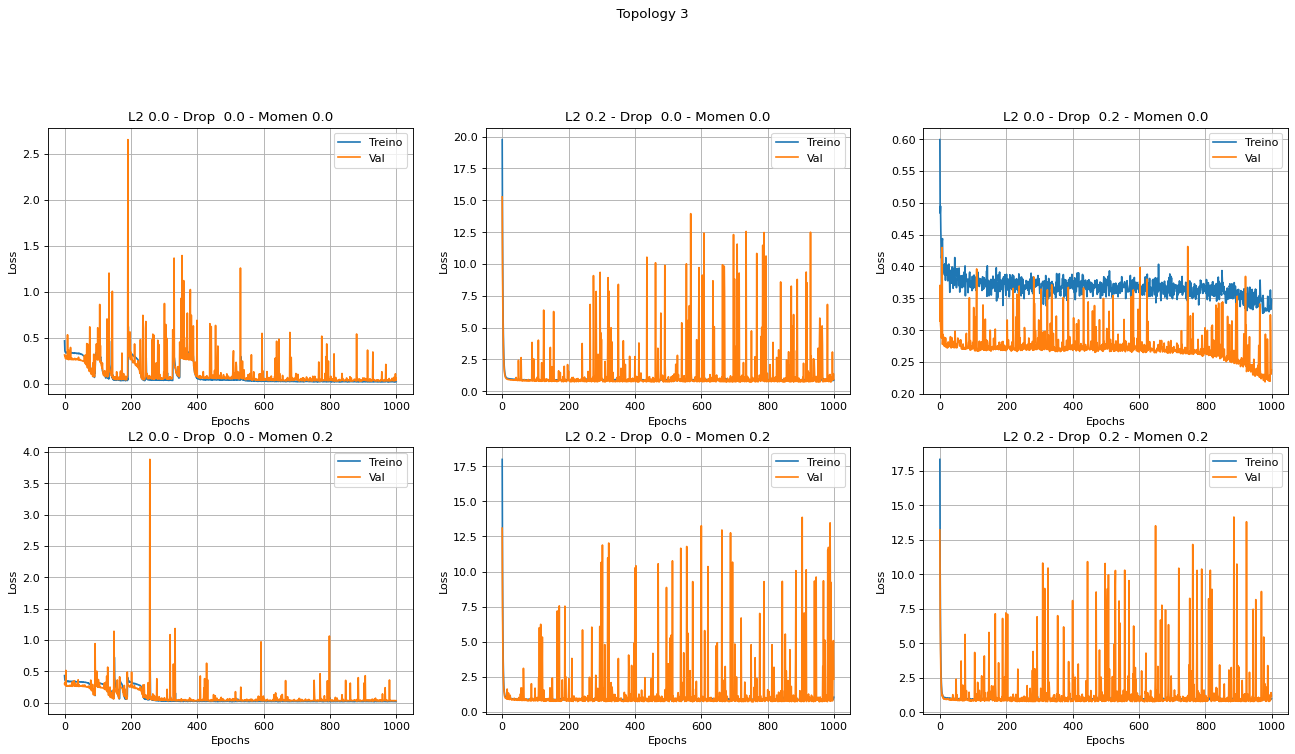

In [23]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 3")
for i in range(len(model_3)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_3[i].history['loss'], label="Treino")
  plt.plot(      history_3[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
  plt.legend()

### Avaliation

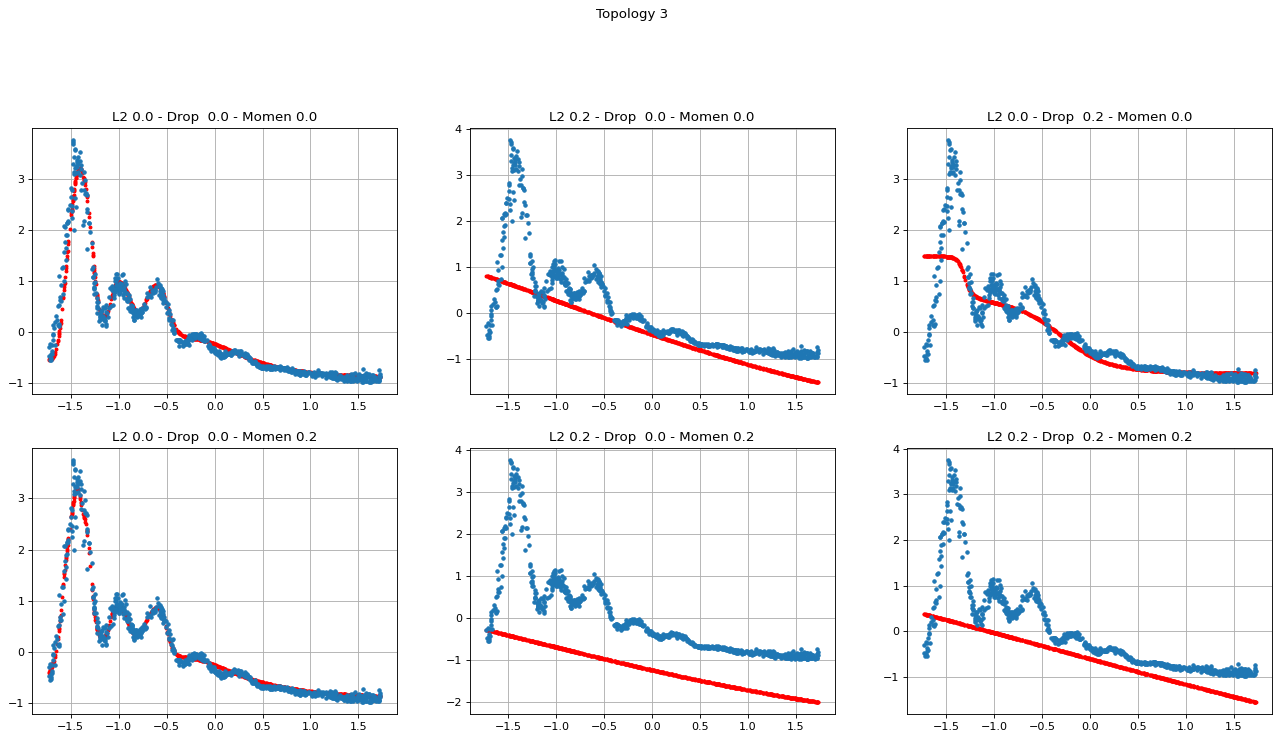

In [24]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 3')
for i in range(len( model_3)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_3[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
#plt.xscale('log')

In [25]:
score_3 = []
for i in range(len(           model_3)): 
  score_3.append(             model_3[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_3'+str(i))
  print("Test loss:",   round(score_3[i][0],5))
  print("Test metric:", round(score_3[i][1],5),'\n')

Model_30
Test loss: 0.04731
Test metric: 0.11817 

Model_31
Test loss: 0.93361
Test metric: 0.47787 

Model_32
Test loss: 0.25995
Test metric: 0.27748 

Model_33
Test loss: 0.02209
Test metric: 0.09231 

Model_34
Test loss: 2.22036
Test metric: 1.19734 

Model_35
Test loss: 1.13044
Test metric: 0.61573 



## Topology 4 


1. 100 Neurons on input layer
2. 200 Neurons on 1º hidden layer
3. 200 Neurons on 2º hidden layer
4. 200 Neurons on 3º hidden layer
4. 100 Neurons on 4º hidden layer
4. 50 Neurons on 4º hidden layer
5. 1 Neurons on output layer

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top4.png?raw=true">

### Models


In [26]:
#Model_4 
model_4 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_4.append(keras.Sequential())
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_4[i].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])


### Training

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___4 = []
endti___4 = []
history_4 = []
for i in range(len(regul)):
  start___4.append(time.time())
  history_4.append(
    model_4[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___4.append(time.time())

### Results

In [28]:
#Time Running Out
for i in range(len(start___4)):
  print(round((    endti___4[i]- start___4[i])/60,5),'minuts')
print(round((      endti___4[-1]-start___4[0])/60,5),'minuts TOTAL')

5.38091 minuts
6.37582 minuts
6.43405 minuts
6.38169 minuts
7.38071 minuts
7.39249 minuts
39.34567 minuts TOTAL


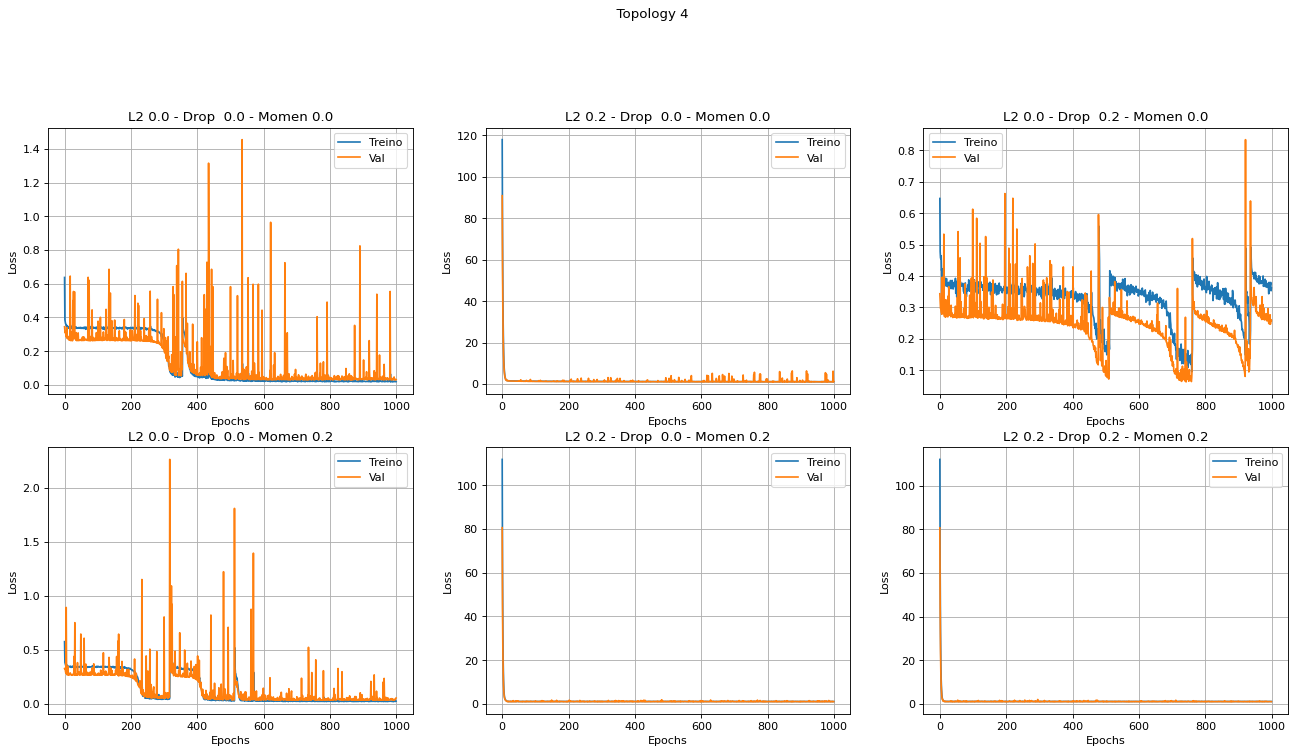

In [29]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 4")
for i in range(len(model_4)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_4[i].history['loss'], label="Treino")
  plt.plot(      history_4[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
  plt.legend()

### Avaliation

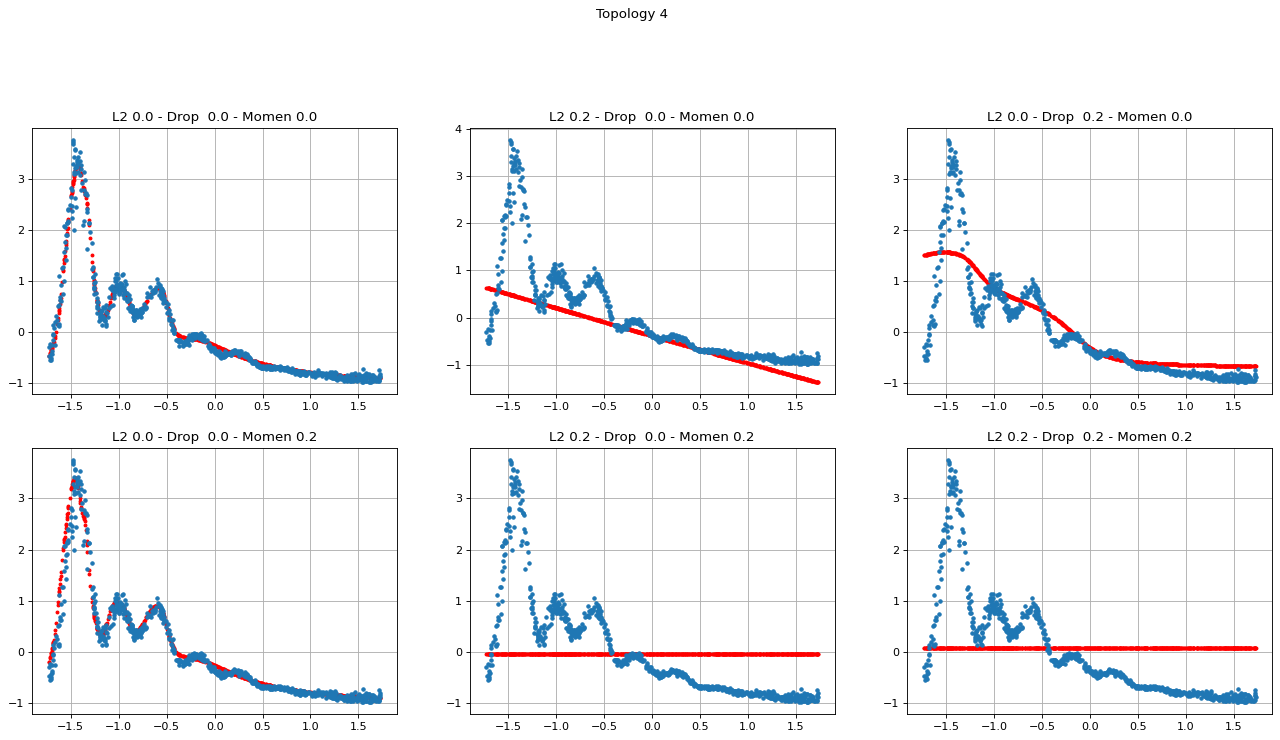

In [30]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 4')
for i in range(len( model_4)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_4[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
#plt.xscale('log')

In [31]:
score_4 = []
for i in range(len(           model_4)): 
  score_4.append(             model_4[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_4'+str(i))
  print("Test loss:",   round(score_4[i][0],5))
  print("Test metric:", round(score_4[i][1],5),'\n')

Model_40
Test loss: 0.02198
Test metric: 0.08726 

Model_41
Test loss: 1.14835
Test metric: 0.41453 

Model_42
Test loss: 0.26547
Test metric: 0.31528 

Model_43
Test loss: 0.04111
Test metric: 0.1115 

Model_44
Test loss: 0.97815
Test metric: 0.75081 

Model_45
Test loss: 0.98539
Test metric: 0.78815 



## Topology 5 


1. 100 Neurons on input layer
2. 200 Neurons on 1º hidden layer
3. 200 Neurons on 2º hidden layer
4. 200 Neurons on 3º hidden layer
4. 100 Neurons on 4º hidden layer
4. 50 Neurons on 4º hidden layer
5. 1 Neurons on output layer

Same topology as Topology 4, but with diferens hyperparameter in the Models

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top4.png?raw=true">



### Models

In [32]:
#Model_5 
model_5 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_5.append(keras.Sequential())
  model_5[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_5[i].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])


### Training

In [33]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___5 = []
endti___5 = []
history_5 = []
for i in range(len(regul)):
  start___5.append(time.time())
  history_5.append(
    model_5[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=0))#, 
  endti___5.append(time.time())

### Results

In [34]:
#Time Running Out
for i in range(len(start___5)):
  print(round((    endti___5[i]- start___5[i])/60,5),'minuts')
print(round((      endti___5[-1]-start___5[0])/60,5),'minuts TOTAL')

5.3798 minuts
4.38052 minuts
3.37806 minuts
3.37663 minuts
3.26304 minuts
3.33629 minuts
23.11435 minuts TOTAL


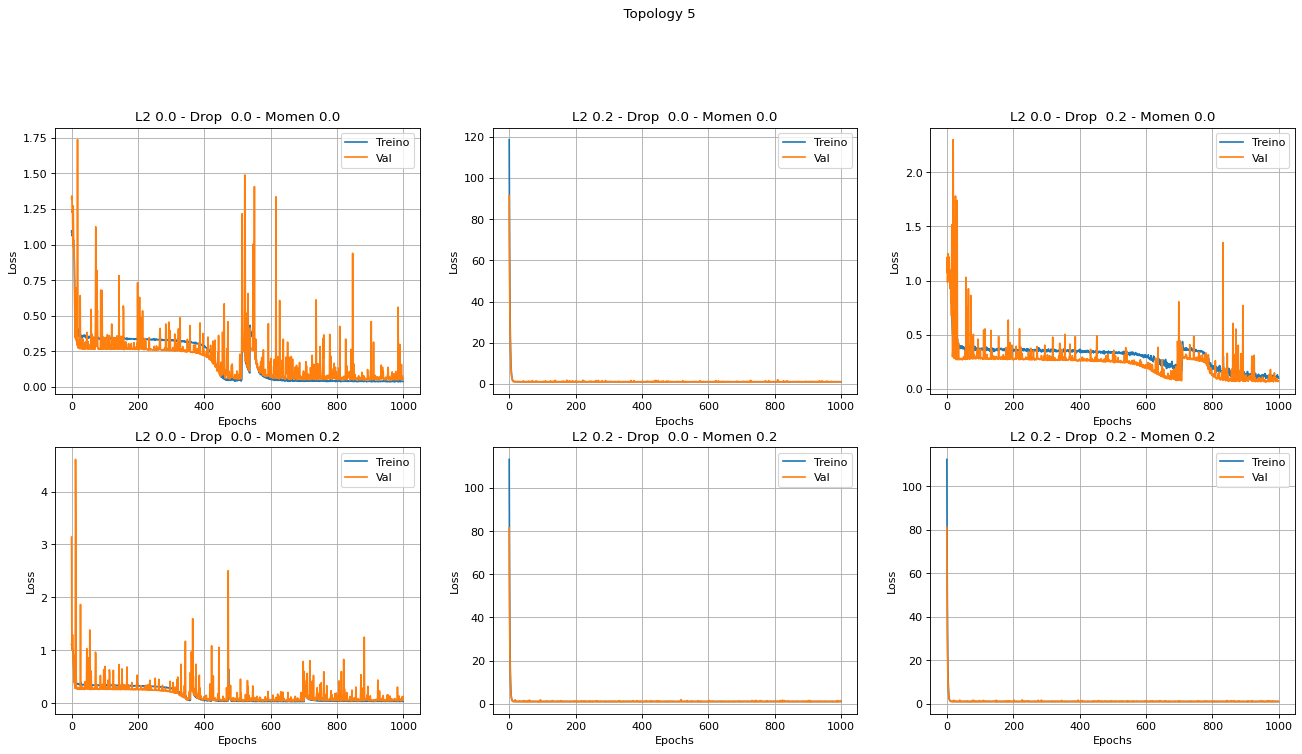

In [35]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 5")
for i in range(len(model_5)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_5[i].history['loss'], label="Treino")
  plt.plot(      history_5[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
  plt.legend()

### Avaliation

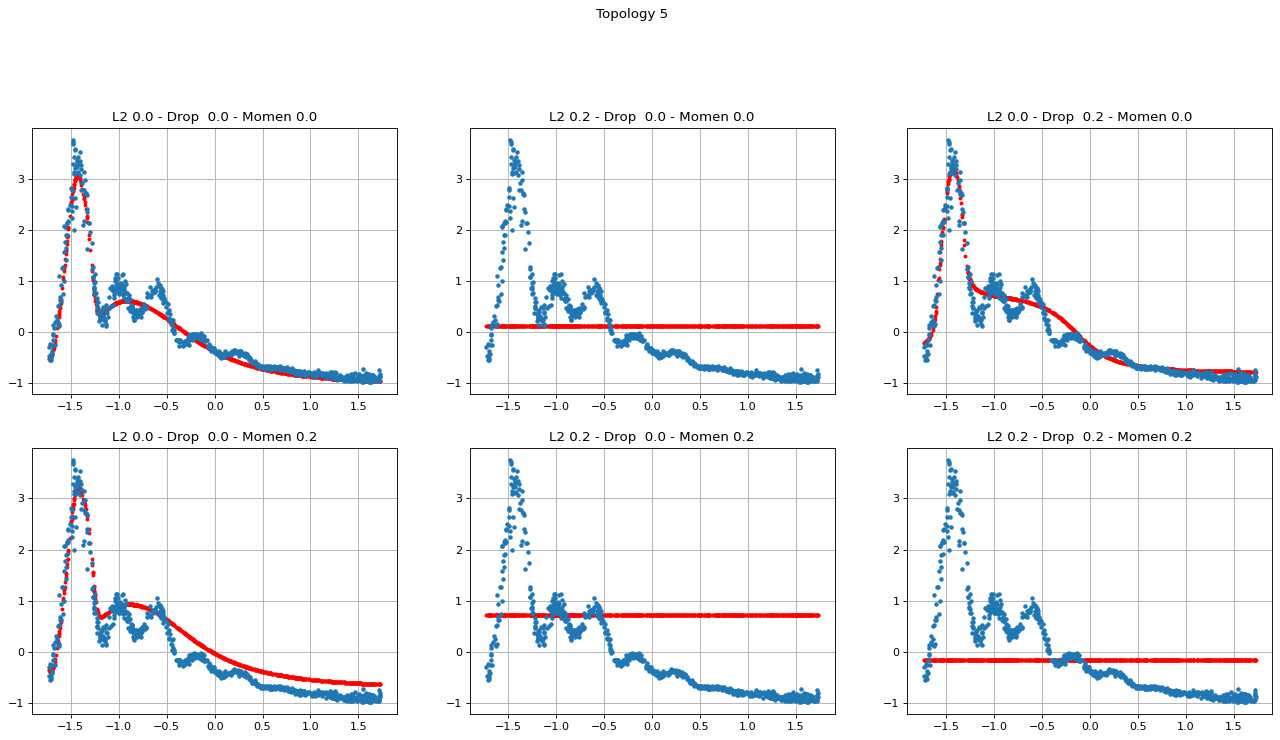

In [36]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 5')
for i in range(len( model_5)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_5[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.grid()
#plt.xscale('log')

In [37]:
score_5 = []
for i in range(len(           model_5)): 
  score_5.append(             model_5[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_5'+str(i))
  print("Test loss:",   round(score_5[i][0],5))
  print("Test metric:", round(score_5[i][1],5),'\n')

Model_50
Test loss: 0.0439
Test metric: 0.14401 

Model_51
Test loss: 0.99288
Test metric: 0.79896 

Model_52
Test loss: 0.05376
Test metric: 0.16739 

Model_53
Test loss: 0.10646
Test metric: 0.28949 

Model_54
Test loss: 1.51375
Test metric: 1.07194 

Model_55
Test loss: 0.99818
Test metric: 0.72613 



# Classification

<img src="https://it.mathworks.com/matlabcentral/mlc-downloads/downloads/aa0a08f6-e2bb-422b-8e89-4c9204fe8424/d133b739-c9b8-45e0-8285-e8fc72f5b2f8/images/screenshot.gif" width = 400>

font https://it.mathworks.com/matlabcentral/fileexchange/74442-visualizing-a-hyper-plane-in-svm-classifier-svm 

For this Classification problem a follow two tutoriais. 

https://www.kaggle.com/code/pedrovinciusmeerholz/nearest-earth-objects-three-models-acc-90

and 

https://www.kaggle.com/code/renangomes/solu-o-simplificada-utilizando-mlp-pt-br/notebook

## Dataset

###NASA - Nearest Earth Objects
*A cumulative data for Nearest Earth Objects by NASA* 

"There is an infinite number of objects in the outer space. Some of them are closer than we think. Even though we might think that a distance of 70,000 Km can not potentially harm us, but at an astronomical scale, this is a very small distance and can disrupt many natural phenomena. These objects/asteroids can thus prove to be harmful. Hence, it is wise to know what is surrounding us and what can harm us amongst those. Thus, this dataset compiles the list of NASA certified asteroids that are classified as the nearest earth object."

https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects

In [1]:
#Importing Librarys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Activation, Dense
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import time


#### Kagle Direcy Donwload

In [3]:
#Monting Google Drive
# https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
#Unziping data-set
!unzip "nasa-nearest-earth-objects.zip" -d "/content/"

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
nasa-nearest-earth-objects.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nasa-nearest-earth-objects.zip
  inflating: /content/neo.csv        
  inflating: /content/neo_v2.csv     


In [4]:
#Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


In [5]:
df_nasa = pd.read_csv('neo.csv')
df_nasa.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True



###  Pre-Processing data

In this point I will take ony the ~columsns~ features usefull for the classification. 

In [6]:
features = df_nasa.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
features.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


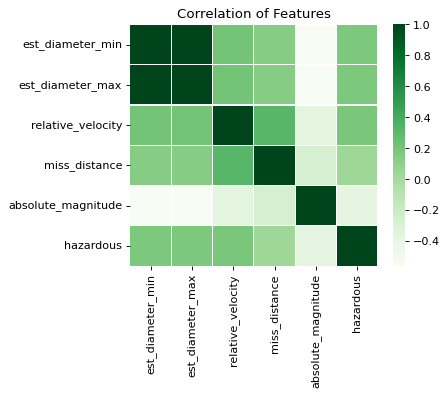

In [7]:
# Correlation Betwenn data
plt.figure(figsize = (5, 4),dpi=80)
plt.title('Correlation of Features')
sns.heatmap(features.astype(float).corr(), linewidths = 0.1, linecolor = 'white', cmap="Greens")
plt.show()

In [8]:
#Defining the feature how will be our classify 🎯
targets = features['hazardous']
features = features.drop('hazardous', axis=1)
targets.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [9]:
#Normalize data
scaler = MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
#features.head()

In [10]:
## Split in Traing and Test
x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=42, test_size=0.3)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Topology NASA 1 

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top_NASA_1.png?raw=true">

### Models

For this first case, the topology will be chosen based on the number of different input features and a single output neuron. The topology being:

1. 5 neurons in the input layer
2. 1 neuron in the output layer

In [15]:
# Model definition
#x_train, x_test, y_train, y_test
#i = 0
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_1 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_1.append(Sequential())
  model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_1[i].add(Dropout(dropo[i]))
  model_NASA_1[i].add(Dense(1, activation='sigmoid'))
  model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

### Training

In [ ]:
epochs = 100
en_time_NASA_1 = []
st_time_NASA_1 = []
history_NASA_1 = []
for i in range(len(regul)):
  st_time_NASA_1.append(time.time())
  history_NASA_1.append(
    model_NASA_1[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=0, shuffle=True))
  en_time_NASA_1.append(time.time())

### Results 

In [ ]:
for i in range(len(regul)):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_1[i] - st_time_NASA_2[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_1[0]- st_time_NASA_2[0])/60,4), "minutes TOTAL")  

In [ ]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 1")
for i in range(len(regul)):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_1[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_1[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')
  plt.grid()

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_1[i].history['loss'], color="C0")
  plt.plot(    history_NASA_1[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.grid()
plt.show()

### Metrics

In [ ]:
print("Training dataset")
print("Accuracy :",round(accuracy_score(y_train.values, np.round(model_NASA_1[i].predict(x_train.values))),6),
    "\nF1_score :",round(      f1_score(y_train.values, np.round(model_NASA_1[i].predict(x_train.values))),6), 
    "\nRecall   :",round(  recall_score(y_train.values, np.round(model_NASA_1[i].predict(x_train.values))),6),
    "\nValidation dataset",
    "\nAccuracy :",round(accuracy_score(y_test.values,  np.round(model_NASA_1[i].predict(x_test.values))),6), "\r")
print("F1_score :",round(      f1_score(y_test.values,  np.round(model_NASA_1[i].predict(x_test.values))),6), "\r")
print("Recall   :",round(  recall_score(y_test.values,  np.round(model_NASA_1[i].predict(x_test.values))),6), "\r\n")


In [ ]:
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('Topology NASA 1')
for i in range(len(regul)):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_1[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_1[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Topology NASA 2 

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top_NASA_2.png?raw=true">

### Models

For this first case, the topology will be chosen based on the number of different input features and a single output neuron. The topology being:

1. 5 neurons in the input layer
2. 1 neuron in the output layer

In [ ]:
# Model definition
#x_train, x_test, y_train, y_test
#i = 0
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_2 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_2.append(Sequential())
  model_NASA_2[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_2[i].add(Dropout(dropo[i]))
  model_NASA_2[i].add(Dense(5, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_2[i].add(Dropout(dropo[i]))
  model_NASA_2[i].add(Dense(5, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_2[i].add(Dropout(dropo[i]))
  model_NASA_2[i].add(Dense(5, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_2[i].add(Dropout(dropo[i]))
  model_NASA_2[i].add(Dense(1, activation='sigmoid'))
  model_NASA_2[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

### Training

In [ ]:
epochs = 100
en_time_NASA_2 = []
st_time_NASA_2 = []
history_NASA_2 = []
for i in range(len(regul)):
  st_time_NASA_2.append(time.time())
  history_NASA_2.append(
    model_NASA_2[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=0, shuffle=True))
  en_time_NASA_2.append(time.time())

### Results 

In [ ]:
for i in range(len(regul)):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_2[i] - st_time_NASA_2[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_2[0]- st_time_NASA_2[0])/60,4), "minutes TOTAL")  

In [ ]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 1")
for i in range(len(regul)):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_2[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_2[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_2[i].history['loss'], color="C0")
  plt.plot(    history_NASA_2[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### Metrics

In [ ]:
print("Training dataset")
print("Accuracy :",round(accuracy_score(y_train.values, np.round(model_NASA_2[i].predict(x_train.values))),6),
    "\nF1_score :",round(      f1_score(y_train.values, np.round(model_NASA_2[i].predict(x_train.values))),6), 
    "\nRecall   :",round(  recall_score(y_train.values, np.round(model_NASA_2[i].predict(x_train.values))),6),
    "\nValidation dataset",
    "\nAccuracy :",round(accuracy_score(y_test.values,  np.round(model_NASA_2[i].predict(x_test.values))),6), "\r")
print("F1_score :",round(      f1_score(y_test.values,  np.round(model_NASA_2[i].predict(x_test.values))),6), "\r")
print("Recall   :",round(  recall_score(y_test.values,  np.round(model_NASA_2[i].predict(x_test.values))),6), "\r\n")


In [ ]:
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('Topology NASA 2')
for i in range(len(regul)):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_2[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_2[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Topology NASA 3 

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top_NASA_3.png?raw=true">

### Models

For this first case, the topology will be chosen based on the number of different input features and a single output neuron. The topology being:

1. 5 neurons in the input layer
2. 1 neuron in the output layer

In [ ]:
# Model definition
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_3 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_3.append(Sequential())
  model_NASA_3[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_3[i].add(Dropout(dropo[i]))
  model_NASA_3[i].add(Dense(10, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_3[i].add(Dropout(dropo[i]))
  model_NASA_3[i].add(Dense(10, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_3[i].add(Dropout(dropo[i]))
  model_NASA_3[i].add(Dense(5, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_3[i].add(Dropout(dropo[i]))
  model_NASA_3[i].add(Dense(1, activation='sigmoid'))
  model_NASA_3[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

### Training

In [ ]:
epochs = 100
en_time_NASA_3 = []
st_time_NASA_3 = []
history_NASA_3 = []
for i in range(len(regul)):
  st_time_NASA_3.append(time.time())
  history_NASA_3.append(
    model_NASA_3[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=0, shuffle=True))
  en_time_NASA_3.append(time.time())

### Results 

In [ ]:
for i in range(len(regul)):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_3[i] - st_time_NASA_3[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_3[0]-  st_time_NASA_3[0])/60,4), "minutes TOTAL")  

In [ ]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 1")
for i in range(len(regul)):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_3[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_3[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')
  plt.grid()

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_3[i].history['loss'], color="C0")
  plt.plot(    history_NASA_3[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.grid()
plt.show()

### Metrics

In [ ]:
print("Training dataset")
print("Accuracy :",round(accuracy_score(y_train.values, np.round(model_NASA_3[i].predict(x_train.values))),6),
    "\nF1_score :",round(      f1_score(y_train.values, np.round(model_NASA_3[i].predict(x_train.values))),6), 
    "\nRecall   :",round(  recall_score(y_train.values, np.round(model_NASA_3[i].predict(x_train.values))),6),
    "\nValidation dataset",
    "\nAccuracy :",round(accuracy_score(y_test.values,  np.round(model_NASA_3[i].predict(x_test.values))),6), "\r")
print("F1_score :",round(      f1_score(y_test.values,  np.round(model_NASA_3[i].predict(x_test.values))),6), "\r")
print("Recall   :",round(  recall_score(y_test.values,  np.round(model_NASA_3[i].predict(x_test.values))),6), "\r\n")


In [ ]:
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('')
for i in range(len(regul)):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_3[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_3[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Topology NASA 4

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top_NASA_4.png?raw=true">

### Models

For this first case, the topology will be chosen based on the number of different input features and a single output neuron. The topology being:

1. 5 neurons in the input layer
2. 1 neuron in the output layer

In [ ]:
# Model definition
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_4 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_4.append(Sequential())
  model_NASA_4[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_4[i].add(Dropout(dropo[i]))
  model_NASA_4[i].add(Dense(50, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_4[i].add(Dropout(dropo[i]))
  model_NASA_4[i].add(Dense(100, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_4[i].add(Dropout(dropo[i]))
  model_NASA_4[i].add(Dense(100, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_4[i].add(Dropout(dropo[i]))
  model_NASA_4[i].add(Dense(50, kernel_regularizer=l2(regul[i]),activation='relu'))
  model_NASA_4[i].add(Dropout(dropo[i]))
  model_NASA_4[i].add(Dense(1, activation='sigmoid'))
  model_NASA_4[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

### Training

In [ ]:
epochs = 100
en_time_NASA_4 = []
st_time_NASA_4 = []
history_NASA_4 = []
for i in range(len(regul)):
  st_time_NASA_4.append(time.time())
  history_NASA_4.append(
    model_NASA_4[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=0, shuffle=True))
  en_time_NASA_4.append(time.time())

### Results 

In [ ]:
for i in range(len(regul)):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_4[i] - st_time_NASA_4[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_4[0]-  st_time_NASA_4[0])/60,4), "minutes TOTAL")  

In [ ]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 4")
for i in range(len(regul)):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_4[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_4[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')
  plt.grid()

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_4[i].history['loss'], color="C0")
  plt.plot(    history_NASA_4[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.grid()
plt.show()

### Metrics

In [ ]:
print("Training dataset")
print("Accuracy :",round(accuracy_score(y_train.values, np.round(model_NASA_4[i].predict(x_train.values))),6),
    "\nF1_score :",round(      f1_score(y_train.values, np.round(model_NASA_4[i].predict(x_train.values))),6), 
    "\nRecall   :",round(  recall_score(y_train.values, np.round(model_NASA_4[i].predict(x_train.values))),6),
    "\nValidation dataset",
    "\nAccuracy :",round(accuracy_score(y_test.values,  np.round(model_NASA_4[i].predict(x_test.values))),6), "\r")
print("F1_score :",round(      f1_score(y_test.values,  np.round(model_NASA_4[i].predict(x_test.values))),6), "\r")
print("Recall   :",round(  recall_score(y_test.values,  np.round(model_NASA_4[i].predict(x_test.values))),6), "\r\n")


In [ ]:
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('')
for i in range(len(regul)):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_4[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_4[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Topology NASA 5

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top_NASA_4.png?raw=true">

### Models

For this first case, the topology will be chosen based on the number of different input features and a single output neuron. The topology being:

1. 5 neurons in the input layer
2. 1 neuron in the output layer

In [ ]:
# Model definition
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]
model_NASA_5 = []
for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_NASA_5.append(Sequential())
  model_NASA_5[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='sigmoid'))
  model_NASA_5[i].add(Dropout(dropo[i]))
  model_NASA_5[i].add(Dense(50, kernel_regularizer=l2(regul[i]),activation='sigmoid'))
  model_NASA_5[i].add(Dropout(dropo[i]))
  model_NASA_5[i].add(Dense(100, kernel_regularizer=l2(regul[i]),activation='sigmoid'))
  model_NASA_5[i].add(Dropout(dropo[i]))
  model_NASA_5[i].add(Dense(100, kernel_regularizer=l2(regul[i]),activation='sigmoid'))
  model_NASA_5[i].add(Dropout(dropo[i]))
  model_NASA_5[i].add(Dense(50, kernel_regularizer=l2(regul[i]),activation='sigmoid'))
  model_NASA_5[i].add(Dropout(dropo[i]))
  model_NASA_5[i].add(Dense(1, activation='sigmoid'))
  model_NASA_5[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()

### Training

In [ ]:
epochs = 100
en_time_NASA_5 = []
st_time_NASA_5 = []
history_NASA_5 = []
for i in range(len(regul)):
  st_time_NASA_5.append(time.time())
  history_NASA_5.append(
    model_NASA_5[i].fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
                      validation_data=(x_test.values,  y_test.values), verbose=0, shuffle=True))
  en_time_NASA_5.append(time.time())

### Results 

In [ ]:
for i in range(len(regul)):
  print('Model NASA 1'+str(i+1))
  print(        round((en_time_NASA_5[i] - st_time_NASA_3[i])/60,4), "minutes\n")
print('TOTAL\n',round((en_time_NASA_5[0]-  st_time_NASA_3[0])/60,4), "minutes TOTAL")  

In [ ]:
N_rows, N_colluns = 6,2

figure(figsize=(18,30),dpi=80)
plt.suptitle("Topology NASA 5")
for i in range(len(regul)):
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.plot(    history_NASA_5[i].history['accuracy'], color="C0")
  plt.plot(    history_NASA_5[i].history['val_accuracy'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'Validation'], loc='lower right')
  plt.grid()

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.plot(    history_NASA_5[i].history['loss'], color="C0")
  plt.plot(    history_NASA_5[i].history['val_loss'], color="C1")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.grid()
plt.show()

### Metrics

In [ ]:
print("Training dataset")
print("Accuracy :",round(accuracy_score(y_train.values, np.round(model_NASA_5[i].predict(x_train.values))),6),
    "\nF1_score :",round(      f1_score(y_train.values, np.round(model_NASA_5[i].predict(x_train.values))),6), 
    "\nRecall   :",round(  recall_score(y_train.values, np.round(model_NASA_5[i].predict(x_train.values))),6),
    "\nValidation dataset",
    "\nAccuracy :",round(accuracy_score(y_test.values,  np.round(model_NASA_5[i].predict(x_test.values))),6), "\r")
print("F1_score :",round(      f1_score(y_test.values,  np.round(model_NASA_5[i].predict(x_test.values))),6), "\r")
print("Recall   :",round(  recall_score(y_test.values,  np.round(model_NASA_5[i].predict(x_test.values))),6), "\r\n")


In [ ]:
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle("Topology NASA 5")
for i in range(len(regul)):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model_NASA_5[i].predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i]))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model_NASA_5[i].predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# References

[HAYKIN, Simon. Redes Neurais: Princípios e prática. Porto Alegre
RS:Bookman, 2001.](https://www.amazon.com.br/Redes-Neurais-Princ%C3%ADpios-Simon-Haykin-ebook/dp/B073QSG69Y)

http://alexlenail.me/NN-SVG/index.html

https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d

https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/